# Transform into a DataFrame logs data.


In [3]:
import os
import json
import pandas as pd

# Directory where your JSON log files are stored.
CURRENT_DIR = os.getcwd()
LOGS_DIR = os.path.join(CURRENT_DIR, "logs")

# Lists to store extracted game-level and round-level data.
games_data = []
choices_data = []

# Iterate over all files in the logs folder.
for filename in os.listdir(LOGS_DIR):
    if filename.endswith('.json'):
        file_path = os.path.join(LOGS_DIR, filename)
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Parse game-level data.
        game_id = data.get("game_id")
        start_time = pd.to_datetime(data.get("start_time"), utc=True)
        completion_time = pd.to_datetime(data.get("completion_time"), utc=True) if data.get("completion_time") else None
        total_duration = data.get("total_duration")
        success = data.get("success")
        
        
        # Retrieve final_choice: either as a top-level key or from within choices.
        final_choice_data = data.get("final_choice")
        if not final_choice_data:
            # Look for an entry in choices with "type": "final_choice".
            for choice in data.get("choices", []):
                if choice.get("type") == "final_choice":
                    final_choice_data = choice
                    break

        if final_choice_data:
            chosen_quadrant = final_choice_data.get("chosen_quadrant")
            correct = final_choice_data.get("correct")
            score = final_choice_data.get("score")
            biased_quadrant = final_choice_data.get("biased_quadrant")
        else:
            chosen_quadrant = None
            correct = None
            score = None
            biased_quadrant = None
            
            
        if "total_duration" not in data or "completion_time" not in data or "success" not in data or "start_time" not in data or "game_id" not in data or not final_choice_data or not data.get("choices"):
            # print(filename)
            continue
        
        games_data.append({
            "game_id": game_id,
            "start_time": start_time,
            "completion_time": completion_time,
            "total_duration": total_duration,
            "success": success,
            "chosen_quadrant": chosen_quadrant,
            "correct": correct,
            "score": score,
            "biased_quadrant": biased_quadrant,
            "source_file": filename  # Track the source file if needed.
        })
        
        # Process each entry in the choices list.
        for choice in data.get("choices", []):
            # Skip the final_choice entry if it was provided inside choices.
            if choice.get("type") == "final_choice":
                continue

            round_num = choice.get("round")
            quadrant = choice.get("quadrant")
            # Use "cue_name" if available; otherwise fallback to "choice".
            cue_name = choice.get("cue_name") if "cue_name" in choice else choice.get("choice")
            color = choice.get("color")
            timestamp = pd.to_datetime(choice.get("timestamp"), utc=True) if choice.get("timestamp") else None

            choices_data.append({
                "game_id": game_id,
                "round": round_num,
                "quadrant": quadrant,
                "cue_name": cue_name,
                "color": color,
                "timestamp": timestamp,
            })

# Convert the lists to pandas DataFrames for further analysis.
games_df = pd.DataFrame(games_data)
choices_df = pd.DataFrame(choices_data)

# Map quadrant values from [0, 1, 2, 3] to [A, B, C, D].
quadrant_mapping = {0: "A", 1: "B", 2: "C", 3: "D"}
games_df["chosen_quadrant"] = games_df["chosen_quadrant"].map(quadrant_mapping)
games_df["biased_quadrant"] = games_df["biased_quadrant"].map(quadrant_mapping)

choices_df['timestamp'] = pd.to_datetime(choices_df['timestamp'])
games_df['start_time'] = pd.to_datetime(games_df['start_time'])

# Sort values and compute time differences per game_id
choices_df = choices_df.sort_values(by=['game_id', 'round'])
choices_df['time_taken (seconds)'] = choices_df.groupby('game_id')['timestamp'].diff()

# For rows where round is 0 (first round), compute the difference from the game's start_time.
game_start_time_map = games_df.set_index('game_id')['start_time']
zero_round_mask = choices_df['round'] == 0
choices_df.loc[zero_round_mask, 'time_taken (seconds)'] = (
    choices_df.loc[zero_round_mask, 'timestamp'] -
    choices_df.loc[zero_round_mask, 'game_id'].map(game_start_time_map)
)

# Convert the resulting timedelta values to seconds.
choices_df['time_taken (seconds)'] = choices_df['time_taken (seconds)'].dt.total_seconds()

# Continue with renaming and dropping columns.
choices_df.rename(columns={'cue_name': 'chosen_quadrant'}, inplace=True)
choices_df.drop(columns=['quadrant'], inplace=True)

print("Choices DataFrame:")
display(choices_df)

# Now, update the games_df as needed.
games_df.rename(columns={'cue_name': 'quadrant'}, inplace=True)

print("Games DataFrame:")
display(games_df.sort_values(by="total_duration", ascending=False))

Choices DataFrame:


,game_id,round,chosen_quadrant,color,timestamp,time_taken (seconds)
283,055af68d-b836-4dd0-8f5e-734fd2da7d1d,0,C,RED,2025-02-11 17:30:58.807000+00:00,1.436363
284,055af68d-b836-4dd0-8f5e-734fd2da7d1d,1,C,GREEN,2025-02-11 17:31:00.261000+00:00,1.454000
285,055af68d-b836-4dd0-8f5e-734fd2da7d1d,2,B,RED,2025-02-11 17:31:02.079000+00:00,1.818000
286,055af68d-b836-4dd0-8f5e-734fd2da7d1d,3,D,RED,2025-02-11 17:31:03.741000+00:00,1.662000
287,055af68d-b836-4dd0-8f5e-734fd2da7d1d,4,C,GREEN,2025-02-11 17:31:05.362000+00:00,1.621000
...,...,...,...,...,...,...
732,fe98e343-1884-4acc-8093-ea6dd9f81c21,0,C,RED,2025-02-13 13:24:15.297000+00:00,1.471990
733,fe98e343-1884-4acc-8093-ea6dd9f81c21,1,D,RED,2025-02-13 13:24:19.371000+00:00,4.074000
734,fe98e343-1884-4acc-8093-ea6dd9f81c21,2,A,GREEN,2025-02-13 13:24:23.272000+00:00,3.901000
735,fe98e343-1884-4acc-8093-ea6dd9f81c21,3,B,RED,2025-02-13 13:24:25.350000+00:00,2.078000


Games DataFrame:


,game_id,start_time,completion_time,total_duration,success,chosen_quadrant,correct,score,biased_quadrant,source_file
16,c8c3b5bb-68cf-4657-807c-7590a0579954,2025-02-13 13:32:26.384222+00:00,2025-02-13 13:45:55.615268+00:00,809.231046,False,D,False,-100,A,game_c8c3b5bb-68cf-4657-807c-7590a0579954.json
34,f863e848-387d-40e1-a4fa-9064e76bfc4d,2025-02-14 20:39:47.852554+00:00,2025-02-14 20:43:56.132081+00:00,248.279527,False,C,False,-100,A,game_f863e848-387d-40e1-a4fa-9064e76bfc4d.json
117,b12cf7e4-8125-4e4c-b038-923fa3c1e645,2025-02-13 13:27:26.931351+00:00,2025-02-13 13:31:30.329723+00:00,243.398372,True,C,True,100,C,game_b12cf7e4-8125-4e4c-b038-923fa3c1e645.json
9,f20d9df6-966b-42c9-9564-5a227e447a0e,2025-02-13 17:08:53.135000+00:00,2025-02-13 17:12:22.773551+00:00,209.638551,True,A,True,100,A,game_f20d9df6-966b-42c9-9564-5a227e447a0e.json
110,91d38a41-a495-4e58-9d00-1de2e86b6d43,2025-02-13 13:32:04.375602+00:00,2025-02-13 13:34:42.449000+00:00,158.073398,True,D,True,100,D,game_91d38a41-a495-4e58-9d00-1de2e86b6d43.json
...,...,...,...,...,...,...,...,...,...,...
6,d69294e8-731e-447f-9f4a-c3e80a08b56d,2025-02-13 14:35:32.302014+00:00,2025-02-13 14:35:38.365003+00:00,6.062989,True,B,True,100,B,game_d69294e8-731e-447f-9f4a-c3e80a08b56d.json
105,9896a898-ac4d-46b7-94db-7192058c50ff,2025-02-10 17:24:38.261393+00:00,2025-02-10 17:24:44.254338+00:00,5.992945,False,B,False,-100,A,game_9896a898-ac4d-46b7-94db-7192058c50ff.json
12,59be0148-38f2-44e5-a7c6-24614d0d6c8a,2025-02-13 13:31:33.182401+00:00,2025-02-13 13:31:38.009506+00:00,4.827105,False,C,False,-100,D,game_59be0148-38f2-44e5-a7c6-24614d0d6c8a.json
94,9b377a61-f5f5-476c-8dfc-8c5073f33db2,2025-02-13 13:24:25.341565+00:00,2025-02-13 13:24:29.797917+00:00,4.456352,False,C,False,-100,D,game_9b377a61-f5f5-476c-8dfc-8c5073f33db2.json


## Games duration visualiation


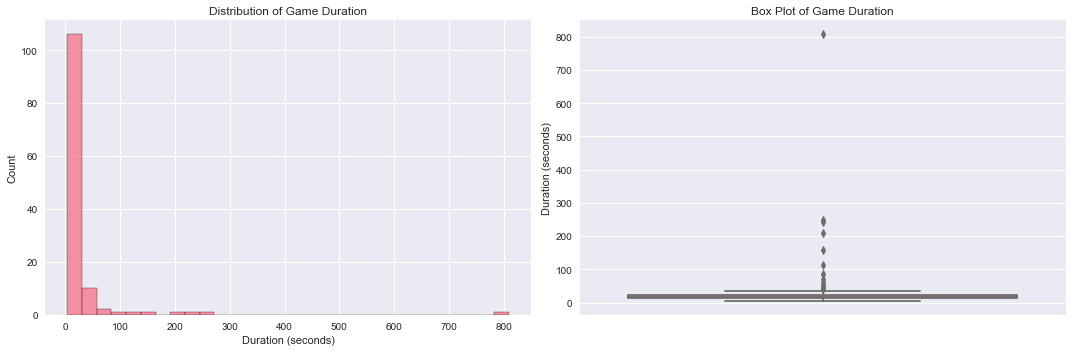


Duration Statistics:
Mean duration: 32.53 seconds
Median duration: 16.89 seconds
Min duration: 3.56 seconds
Max duration: 809.23 seconds
Standard deviation: 79.69 seconds

95th percentile of game durations: 84.01 seconds
5th percentile of game durations: 6.28 seconds

Removed 14 games (both top and bottom 5% extremes).


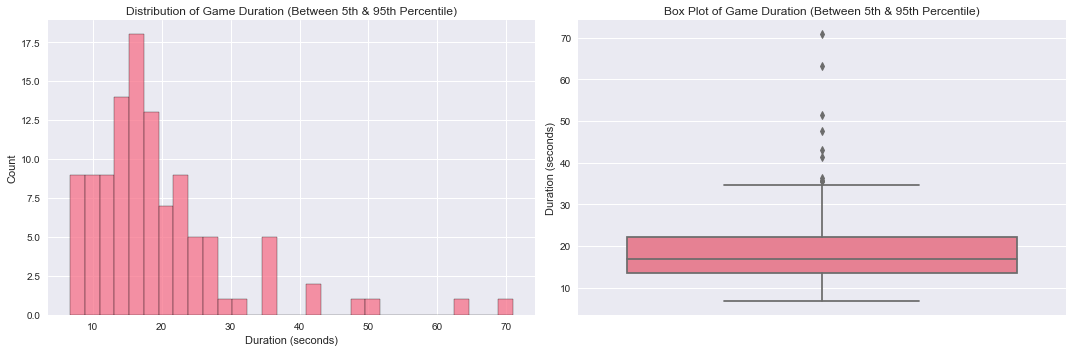


Number of games after filtering: 111
Number of choices corresponding to these games: 834


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
plt.style.use('seaborn')
sns.set_palette("husl")

# Create a figure with two subplots to visualize the original distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of game durations
sns.histplot(data=games_df, x="total_duration", bins=30, ax=ax1)
ax1.set_title("Distribution of Game Duration")
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("Count")

# Box plot of game durations
sns.boxplot(data=games_df, y="total_duration", ax=ax2)
ax2.set_title("Box Plot of Game Duration")
ax2.set_ylabel("Duration (seconds)")

plt.tight_layout()
plt.show()

# Print some basic statistics about game durations
print("\nDuration Statistics:")
print(f"Mean duration: {games_df['total_duration'].mean():.2f} seconds")
print(f"Median duration: {games_df['total_duration'].median():.2f} seconds")
print(f"Min duration: {games_df['total_duration'].min():.2f} seconds")
print(f"Max duration: {games_df['total_duration'].max():.2f} seconds")
print(f"Standard deviation: {games_df['total_duration'].std():.2f} seconds")

# Calculate the 95th and 5th percentile thresholds for game durations.
duration_95th_quantile = games_df['total_duration'].quantile(0.95)
duration_5th_quantile = games_df['total_duration'].quantile(0.05)
print(f"\n95th percentile of game durations: {duration_95th_quantile:.2f} seconds")
print(f"5th percentile of game durations: {duration_5th_quantile:.2f} seconds")

# Filter games to include only those with durations between the 5th and 95th percentiles,
# effectively removing the top 5% longest and bottom 5% shortest-duration games.
filtered_games_df = games_df[(games_df['total_duration'] >= duration_5th_quantile) &
                             (games_df['total_duration'] <= duration_95th_quantile)]
removed_games = len(games_df) - len(filtered_games_df)
print(f"\nRemoved {removed_games} games (both top and bottom 5% extremes).")

# Optionally, plot the distribution for the filtered set.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram for filtered game durations
sns.histplot(data=filtered_games_df, x='total_duration', bins=30, ax=ax1)
ax1.set_title("Distribution of Game Duration (Between 5th & 95th Percentile)")
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("Count")

# Box plot for filtered game durations
sns.boxplot(data=filtered_games_df, y='total_duration', ax=ax2)
ax2.set_title("Box Plot of Game Duration (Between 5th & 95th Percentile)")
ax2.set_ylabel("Duration (seconds)")

plt.tight_layout()
plt.show()

# Update the filtering for the choices DataFrame using the filtered game_ids.
filtered_game_ids = filtered_games_df['game_id'].unique()
filtered_choices_df = choices_df[choices_df['game_id'].isin(filtered_game_ids)]
print(f"\nNumber of games after filtering: {len(filtered_games_df)}")
print(f"Number of choices corresponding to these games: {len(filtered_choices_df)}")


## Mean Thinking Time Analysis Per Round

In [1]:
import matplotlib.pyplot as plt


valid_choices = filtered_choices_df.dropna(subset=['time_taken (seconds)'])

# Thinking time shouldn't be greater than 5 seconds
valid_choices = valid_choices[valid_choices['time_taken (seconds)'] <= 5]

# Group by round and aggregate:
# - Mean thinking time for rounds
# - Number of unique games contributing to each round
evolution_by_round = valid_choices.groupby('round').agg({
    'time_taken (seconds)': 'mean',
    'game_id': 'nunique'
}).reset_index().rename(
    columns={
        'time_taken (seconds)': 'mean_thinking_time',
        'game_id': 'num_games'
    }
)

print("Evolution of Thinking Time by Round (aggregated):")
evolution_by_round = evolution_by_round[evolution_by_round['num_games'] > 10]
display(evolution_by_round)

# Set up the figure and axes.
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean thinking time as a line plot on the primary y-axis
color_line = 'tab:blue'
ax1.set_xlabel('Round')
ax1.set_ylabel('Mean Thinking Time (seconds)', color=color_line)
ax1.plot(evolution_by_round['round'], evolution_by_round['mean_thinking_time'], marker='o', linestyle='-', color=color_line, label='Mean Thinking Time')
ax1.tick_params(axis='y', labelcolor=color_line)

# Create a secondary y-axis for the number of games count
ax2 = ax1.twinx()
color_bar = 'tab:orange'
ax2.set_ylabel('Number of Games', color=color_bar)
ax2.bar(evolution_by_round['round'], evolution_by_round['num_games'], alpha=0.3, color=color_bar, label='Number of Games')
ax2.tick_params(axis='y', labelcolor=color_bar)

# Add a title and grid
plt.title('Evolution of Mean Thinking Time by Round with Game Count')
plt.grid(True)

# Optionally, add legends for clarity.
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper left')

plt.show()


NameError: name 'filtered_choices_df' is not defined

# Strategy vs Exploration

Overall Reaction Time Analysis:
   is_strategy      mean       std  count
0        False  1.824036  0.687791    524
1         True  1.760228  0.587235     79


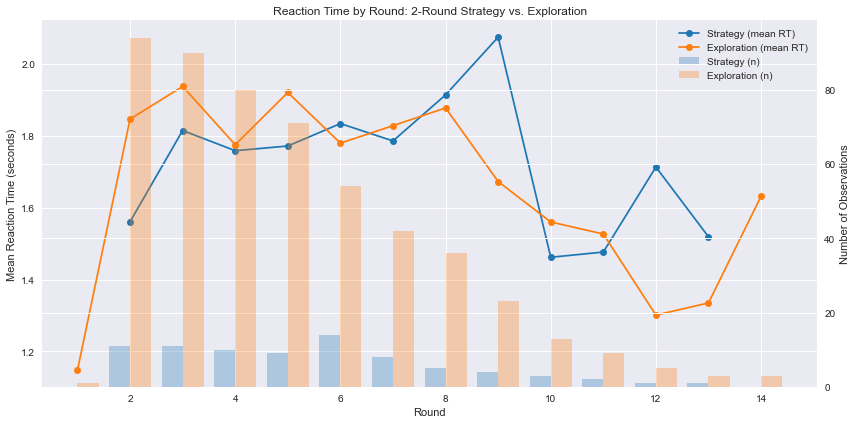

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Sort the dataframe by game and round order.
df = filtered_choices_df.sort_values(by=['game_id', 'round']).copy()

# Create two shifted columns: one for the immediately previous round and one for the round before that.
df['prev_choice_1'] = df.groupby('game_id')['chosen_quadrant'].shift(1)
df['prev_choice_2'] = df.groupby('game_id')['chosen_quadrant'].shift(2)

# Label as 'strategy' only if the current choice is the same as both previous rounds.
df['is_strategy'] = (
    (df['chosen_quadrant'] == df['prev_choice_1']) &
    (df['chosen_quadrant'] == df['prev_choice_2'])
)

# Remove rounds where there are not two previous choices for a valid comparison.
df_clean = df.dropna(subset=['prev_choice_1', 'prev_choice_2'])

# Filter out outliers: Keep only reaction times <= 5 seconds.
df_clean = df_clean[df_clean['time_taken (seconds)'] <= 5]

# Compute overall reaction times by behavior.
overall_rt = df_clean.groupby('is_strategy')['time_taken (seconds)'].agg(['mean', 'std', 'count']).reset_index()
print("Overall Reaction Time Analysis:")
print(overall_rt)

# Compute average reaction times per round for each behavior (strategy vs. exploration).
rt_by_round = df_clean.groupby(['round', 'is_strategy'])['time_taken (seconds)'].mean().reset_index()


# Separate the data for the two behaviors.
strategy_rt = rt_by_round[rt_by_round['is_strategy'] == True]
exploration_rt = rt_by_round[rt_by_round['is_strategy'] == False]


# ----------------------------------------------------------------------------
# Step 5 (updated): Reaction Time and Count by Round
# ----------------------------------------------------------------------------
rt_by_round = (
    df_clean
    .groupby(['round', 'is_strategy'])['time_taken (seconds)']
    .agg(['mean', 'count'])
    .reset_index()
)

# Separate the data for the two behaviors.
strategy_rt = rt_by_round[rt_by_round['is_strategy'] == True]
exploration_rt = rt_by_round[rt_by_round['is_strategy'] == False]

# ----------------------------------------------------------------------------
# Step 6: Plotting with Dual Axes
# ----------------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot: Mean reaction times
ln1 = ax1.plot(strategy_rt['round'], strategy_rt['mean'],
               marker='o', linestyle='-', label='Strategy (mean RT)', color='tab:blue')
ln2 = ax1.plot(exploration_rt['round'], exploration_rt['mean'],
               marker='o', linestyle='-', label='Exploration (mean RT)', color='tab:orange')

ax1.set_xlabel('Round')
ax1.set_ylabel('Mean Reaction Time (seconds)')
ax1.set_title('Reaction Time by Round: 2-Round Strategy vs. Exploration')
ax1.grid(True)

# Second y-axis for count bars
ax2 = ax1.twinx()
bar_width = 0.4

# Bar plot: Counts per round
bars1 = ax2.bar(strategy_rt['round'] - bar_width/2, strategy_rt['count'],
                width=bar_width, alpha=0.3, color='tab:blue', label='Strategy (n)')
bars2 = ax2.bar(exploration_rt['round'] + bar_width/2, exploration_rt['count'],
                width=bar_width, alpha=0.3, color='tab:orange', label='Exploration (n)')

ax2.set_ylabel('Number of Observations')

# Combine legends from both axes
lines = ln1 + ln2 + [bars1, bars2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()



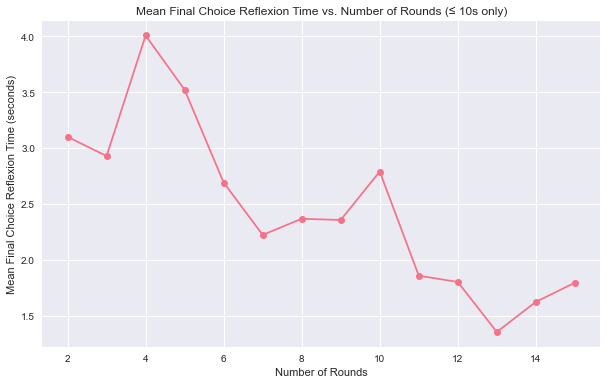

In [14]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt


# For each game, compute the last round timestamp from choices_df.
last_round_times = choices_df.groupby("game_id")["timestamp"].max()
games_df["last_round_timestamp"] = games_df["game_id"].map(last_round_times)

# Ensure both the completion_time and last_round_timestamp are in datetime format.
games_df["completion_time"] = pd.to_datetime(games_df["completion_time"], utc=True)
games_df["last_round_timestamp"] = pd.to_datetime(games_df["last_round_timestamp"], utc=True)

# Compute the final choice reflexion time (in seconds) as the difference between
# the game's completion_time and the last round timestamp.
games_df["final_choice_reflexion_time"] = (
    games_df["completion_time"] - games_df["last_round_timestamp"]
).dt.total_seconds()



# First, compute number of rounds per game
num_rounds = choices_df.groupby("game_id")["round"].nunique()
games_df["num_rounds"] = games_df["game_id"].map(num_rounds)

# Filter out reflexion times greater than 10 seconds and null values
filtered_games = games_df[
    (games_df["final_choice_reflexion_time"].notnull()) &
    (games_df["final_choice_reflexion_time"] <= 10)
]

# Group by number of rounds and compute mean reflexion time
rounds_vs_reflexion = (
    filtered_games
    .groupby("num_rounds")["final_choice_reflexion_time"]
    .mean()
    .reset_index()
)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(rounds_vs_reflexion["num_rounds"], rounds_vs_reflexion["final_choice_reflexion_time"], marker='o')
plt.xlabel("Number of Rounds")
plt.ylabel("Mean Final Choice Reflexion Time (seconds)")
plt.title("Mean Final Choice Reflexion Time vs. Number of Rounds (≤ 10s only)")
plt.grid(True)
plt.show()


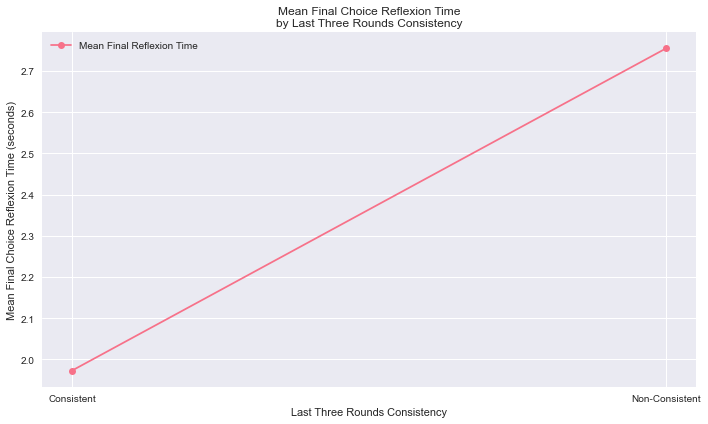

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def last_three_consistency(group):
    last_three = group.sort_values("round").tail(3)
    if len(last_three) < 3:
        return np.nan
    return last_three["chosen_quadrant"].nunique() == 1

# Apply the consistency logic
consistency_flag = choices_df.groupby("game_id").apply(last_three_consistency)
games_df["last3_consistent"] = games_df["game_id"].map(consistency_flag)


valid_games = games_df[
    games_df["final_choice_reflexion_time"].notnull() & 
    games_df["last3_consistent"].notnull() & 
    (games_df["final_choice_reflexion_time"] <= 10)
].copy()


grouped_consistency = (
    valid_games.groupby("last3_consistent")["final_choice_reflexion_time"]
    .mean()
    .reset_index()
)

grouped_consistency["Consistency"] = grouped_consistency["last3_consistent"].map({
    True: "Consistent", 
    False: "Non-Consistent"
})
grouped_consistency = grouped_consistency.sort_values("Consistency")


plt.figure(figsize=(10, 6))
plt.plot(grouped_consistency["Consistency"], grouped_consistency["final_choice_reflexion_time"],
         marker='o', linestyle='-', label='Mean Final Reflexion Time')
plt.xlabel("Last Three Rounds Consistency")
plt.ylabel("Mean Final Choice Reflexion Time (seconds)")
plt.title("Mean Final Choice Reflexion Time\nby Last Three Rounds Consistency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
